## Using Satellite-Derived Surface Temperature Near Oil Refineries to Predict Heating Oil Prices

In [25]:
import os
import sys
import re
import time
import json
import pickle
import random
import logging
import tarfile
import tempfile
import traceback
import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import xarray as xr
import h5py
import pygrib
import netCDF4 as nc
import cv2

import requests
import pydap

import cloudpickle
import zstandard as zstd

from multiprocessing import Pool
from joblib import Parallel, delayed, parallel_backend

from pyhdf.SD import SD, SDC

import platform

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# print(os.getcwd())

## Extract MODIS

In [26]:
modis_df = pd.read_csv('C:\oqg_proj1\data\modis_features.csv')
modis_df

<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:1: SyntaxWarning: invalid escape sequence '\o'
C:\Users\mattl\AppData\Local\Temp\ipykernel_25256\300931030.py:1: SyntaxWarning: invalid escape sequence '\o'
  modis_df = pd.read_csv('C:\oqg_proj1\data\modis_features.csv')


,granule_id,us_url,product,location,split,granuleSize,lst_day_1km_min,lst_day_1km_max,lst_day_1km_mean,qc_day_min,...,emis_31_mean,emis_32_min,emis_32_max,emis_32_mean,clear_sky_days_min,clear_sky_days_max,clear_sky_days_mean,clear_sky_nights_min,clear_sky_nights_max,clear_sky_nights_mean
0,MOD11A2.A2025057.h11v05.061.2025066040222.hdf,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,modis,northeast,train,5687879,13215.0,14909.0,14233.141216,2.0,...,246.018940,240.0,249.0,247.521889,1.0,255.0,78.119237,1.0,255.0,90.746591
1,MOD11A2.A2025057.h11v04.061.2025066040453.hdf,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,modis,northeast,train,9134100,12439.0,14480.0,13730.955944,2.0,...,247.413874,239.0,250.0,248.189789,1.0,255.0,55.789091,1.0,255.0,57.361132
2,MOD11A2.A2025113.h13v04.061.2025125151119.hdf,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,modis,northeast,train,4113599,12785.0,14909.0,14185.654210,2.0,...,246.476923,241.0,250.0,247.351274,1.0,247.0,88.326803,1.0,247.0,58.956850
3,MOD11A2.A2025113.h12v05.061.2025125151656.hdf,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,modis,northeast,train,1532441,14169.0,15340.0,14767.663602,2.0,...,246.023359,240.0,249.0,247.334322,1.0,254.0,191.621547,2.0,178.0,86.213160
4,MOD11A2.A2025113.h11v04.061.2025125151312.hdf,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,modis,northeast,train,8371753,13362.0,15601.0,14525.358490,2.0,...,246.869933,242.0,250.0,247.822955,1.0,255.0,100.919004,1.0,255.0,137.524624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,MOD11A2.A2000049.h13v04.061.2020048120504.hdf,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,modis,northeast,train,3132212,12845.0,14085.0,13502.080517,2.0,...,248.278705,240.0,250.0,248.325474,1.0,3.0,2.446879,2.0,2.0,2.000000
5783,MOD11A2.A2000049.h12v04.061.2020048120247.hdf,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,modis,northeast,train,2877506,12526.0,14834.0,13610.712627,2.0,...,248.005439,240.0,250.0,247.935645,1.0,3.0,1.789470,2.0,2.0,2.000000
5784,MOD11A2.A2000049.h11v04.061.2020048120245.hdf,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,modis,northeast,train,3098988,12865.0,14799.0,13890.190453,2.0,...,247.157511,239.0,250.0,247.992151,1.0,3.0,1.105508,2.0,2.0,2.000000
5785,MOD11A2.A2000049.h11v05.061.2020048120246.hdf,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,modis,northeast,train,4211435,13492.0,15154.0,14707.012774,2.0,...,246.020054,240.0,250.0,247.551559,1.0,3.0,2.038098,2.0,2.0,2.000000


In [27]:
from datetime import datetime, timedelta


# Sample extract_date function
def extract_date(granule_id):
    try:
        date_str = granule_id.split('.')[1]  # 'A2025057'
        year = int(date_str[1:5])            # 2025
        doy = int(date_str[5:])              # 057
        return datetime.strptime(f'{year}-{doy}', '%Y-%j')
    except Exception as e:
        print(f"Error parsing {granule_id}: {e}")
        return pd.NaT

# Apply to your DataFrame
modis_df['date'] = modis_df['granule_id'].apply(extract_date)
modis_df = modis_df[['date'] + [col for col in modis_df.columns if col != 'date']]

modis_df['date']

0      2025-02-26
1      2025-02-26
2      2025-04-23
3      2025-04-23
4      2025-04-23
          ...    
5782   2000-02-18
5783   2000-02-18
5784   2000-02-18
5785   2000-02-18
5786   2000-02-18
Name: date, Length: 5787, dtype: datetime64[ns]

## HO=F Futures Data

In [28]:
ho_df = pd.read_csv('data\heating_oil_historical.csv')
ho_df = ho_df.rename(columns={'Date': 'date'})
ho_df

<>:1: SyntaxWarning: invalid escape sequence '\h'
<>:1: SyntaxWarning: invalid escape sequence '\h'
C:\Users\mattl\AppData\Local\Temp\ipykernel_25256\1412001977.py:1: SyntaxWarning: invalid escape sequence '\h'
  ho_df = pd.read_csv('data\heating_oil_historical.csv')


,date,Open,High,Low,Close,Adj Close,Volume
0,31-Dec-24,2.3105,2.3315,2.2892,2.3206,2.3206,54430
1,30-Dec-24,2.2405,2.3173,2.2397,2.2995,2.2995,19299
2,27-Dec-24,2.2065,2.2564,2.1990,2.2448,2.2448,17139
3,26-Dec-24,2.2230,2.2494,2.1969,2.2053,2.2053,17639
4,24-Dec-24,2.2387,2.2498,2.2169,2.2215,2.2215,15731
...,...,...,...,...,...,...,...
2510,8-Jan-15,1.6970,1.7195,1.6766,1.7110,1.7110,67237
2511,7-Jan-15,1.7020,1.7256,1.6715,1.6999,1.6999,75085
2512,6-Jan-15,1.7500,1.7629,1.7025,1.7262,1.7262,73014
2513,5-Jan-15,1.7955,1.7996,1.7386,1.7492,1.7492,66059


## Data Cleaning

In [29]:
# Ensure they're both datetime

modis_df['date'] = pd.to_datetime(modis_df['date'])
ho_df['date'] = pd.to_datetime(ho_df['date'])

C:\Users\mattl\AppData\Local\Temp\ipykernel_25256\47617160.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ho_df['date'] = pd.to_datetime(ho_df['date'])


In [30]:
modis_filtered = modis_df[(modis_df['date'] >= '2015-01-01') & (modis_df['date'] < '2025-01-01')]
ho_filtered = ho_df[(ho_df['date'] >= '2015-01-01') & (ho_df['date'] < '2025-01-01')]

In [31]:
modis_filtered.head()

,date,granule_id,us_url,product,location,split,granuleSize,lst_day_1km_min,lst_day_1km_max,lst_day_1km_mean,...,emis_31_mean,emis_32_min,emis_32_max,emis_32_mean,clear_sky_days_min,clear_sky_days_max,clear_sky_days_mean,clear_sky_nights_min,clear_sky_nights_max,clear_sky_nights_mean
77,2024-12-26,MOD11A2.A2024361.h12v05.061.2025004043511.hdf,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,modis,northeast,train,1513871,13501.0,14491.0,14047.138944,...,246.110360,241.0,250.0,247.524009,1.0,59.0,35.167663,2.0,42.0,33.590934
78,2024-12-26,MOD11A2.A2024361.h11v05.061.2025004043509.hdf,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,modis,northeast,train,4883421,12753.0,14744.0,14188.881093,...,246.093870,241.0,250.0,247.543962,1.0,61.0,22.390567,1.0,63.0,34.877420
79,2024-12-26,MOD11A2.A2024361.h12v04.061.2025004045034.hdf,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,modis,northeast,train,6801969,11900.0,14301.0,13505.152165,...,247.775720,239.0,250.0,247.867372,1.0,61.0,19.191357,1.0,63.0,24.583432
80,2024-12-26,MOD11A2.A2024361.h11v04.061.2025004045454.hdf,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,modis,northeast,train,6810076,12218.0,14383.0,13582.803038,...,247.801104,240.0,250.0,248.426143,1.0,63.0,11.553038,1.0,63.0,21.604726
81,2024-12-26,MOD11A2.A2024361.h13v04.061.2025004070813.hdf,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,modis,northeast,train,4269000,12394.0,14066.0,13153.476766,...,249.163804,240.0,250.0,248.758363,1.0,53.0,11.615224,1.0,59.0,16.138557


In [32]:
ho_filtered.head()

,date,Open,High,Low,Close,Adj Close,Volume
0,2024-12-31,2.3105,2.3315,2.2892,2.3206,2.3206,54430
1,2024-12-30,2.2405,2.3173,2.2397,2.2995,2.2995,19299
2,2024-12-27,2.2065,2.2564,2.1990,2.2448,2.2448,17139
3,2024-12-26,2.2230,2.2494,2.1969,2.2053,2.2053,17639
4,2024-12-24,2.2387,2.2498,2.2169,2.2215,2.2215,15731


In [33]:
# Step 1: Aggregate MODIS by date (mean of all granules on the same day)
modis_daily = modis_filtered.groupby('date').mean(numeric_only=True).reset_index()

# Step 2: Sort both DataFrames
modis_daily = modis_daily.sort_values('date')
ho_filtered = ho_filtered.sort_values('date')

# Step 3: Use merge_asof to join each oil price with most recent MODIS data
merged_df = pd.merge_asof(
    ho_filtered,
    modis_daily,
    on='date',
    direction='backward'  # use latest past MODIS date
)

print(merged_df.shape)  # Should be close to ho_filtered.shape (~1000 rows)
merged_df

(2515, 44)


,date,Open,High,Low,Close,Adj Close,Volume,granuleSize,lst_day_1km_min,lst_day_1km_max,...,emis_31_mean,emis_32_min,emis_32_max,emis_32_mean,clear_sky_days_min,clear_sky_days_max,clear_sky_days_mean,clear_sky_nights_min,clear_sky_nights_max,clear_sky_nights_mean
0,2015-01-02,1.8533,1.8774,1.7871,1.7957,1.7957,46068,5862447.2,12239.6,14334.4,...,247.595641,239.6,250.0,248.131797,1.0,243.8,66.504794,1.0,246.0,79.089341
1,2015-01-05,1.7955,1.7996,1.7386,1.7492,1.7492,66059,5862447.2,12239.6,14334.4,...,247.595641,239.6,250.0,248.131797,1.0,243.8,66.504794,1.0,246.0,79.089341
2,2015-01-06,1.7500,1.7629,1.7025,1.7262,1.7262,73014,5862447.2,12239.6,14334.4,...,247.595641,239.6,250.0,248.131797,1.0,243.8,66.504794,1.0,246.0,79.089341
3,2015-01-07,1.7020,1.7256,1.6715,1.6999,1.6999,75085,5862447.2,12239.6,14334.4,...,247.595641,239.6,250.0,248.131797,1.0,243.8,66.504794,1.0,246.0,79.089341
4,2015-01-08,1.6970,1.7195,1.6766,1.7110,1.7110,67237,5862447.2,12239.6,14334.4,...,247.595641,239.6,250.0,248.131797,1.0,243.8,66.504794,1.0,246.0,79.089341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,2024-12-24,2.2387,2.2498,2.2169,2.2215,2.2215,15731,5799593.2,12498.8,14378.4,...,247.598708,240.2,250.0,248.080681,1.0,253.6,72.194323,1.0,253.0,82.092066
2511,2024-12-26,2.2230,2.2494,2.1969,2.2053,2.2053,17639,4855667.4,12553.2,14397.0,...,247.388972,240.2,250.0,248.023970,1.0,59.4,19.983570,1.2,58.0,26.159014
2512,2024-12-27,2.2065,2.2564,2.1990,2.2448,2.2448,17139,4855667.4,12553.2,14397.0,...,247.388972,240.2,250.0,248.023970,1.0,59.4,19.983570,1.2,58.0,26.159014
2513,2024-12-30,2.2405,2.3173,2.2397,2.2995,2.2995,19299,4855667.4,12553.2,14397.0,...,247.388972,240.2,250.0,248.023970,1.0,59.4,19.983570,1.2,58.0,26.159014


In [34]:
# List of columns to drop (case-insensitive and cleaned)
cols_to_drop = ['open', 'high', 'low', 'adj_close', 'granulesize']

# Ensure column names are normalized
merged_df.columns = merged_df.columns.str.strip().str.lower().str.replace('*', '', regex=False).str.replace(' ', '_')

# Drop the specified columns
merged_df = merged_df.drop(columns=cols_to_drop)

# Preview result
merged_df.head()


,date,close,volume,lst_day_1km_min,lst_day_1km_max,lst_day_1km_mean,qc_day_min,qc_day_max,qc_day_mean,day_view_time_min,...,emis_31_mean,emis_32_min,emis_32_max,emis_32_mean,clear_sky_days_min,clear_sky_days_max,clear_sky_days_mean,clear_sky_nights_min,clear_sky_nights_max,clear_sky_nights_mean
0,2015-01-02,1.7957,46068,12239.6,14334.4,13233.65539,2.0,148.2,25.744033,101.0,...,247.595641,239.6,250.0,248.131797,1.0,243.8,66.504794,1.0,246.0,79.089341
1,2015-01-05,1.7492,66059,12239.6,14334.4,13233.65539,2.0,148.2,25.744033,101.0,...,247.595641,239.6,250.0,248.131797,1.0,243.8,66.504794,1.0,246.0,79.089341
2,2015-01-06,1.7262,73014,12239.6,14334.4,13233.65539,2.0,148.2,25.744033,101.0,...,247.595641,239.6,250.0,248.131797,1.0,243.8,66.504794,1.0,246.0,79.089341
3,2015-01-07,1.6999,75085,12239.6,14334.4,13233.65539,2.0,148.2,25.744033,101.0,...,247.595641,239.6,250.0,248.131797,1.0,243.8,66.504794,1.0,246.0,79.089341
4,2015-01-08,1.7110,67237,12239.6,14334.4,13233.65539,2.0,148.2,25.744033,101.0,...,247.595641,239.6,250.0,248.131797,1.0,243.8,66.504794,1.0,246.0,79.089341


## Inference

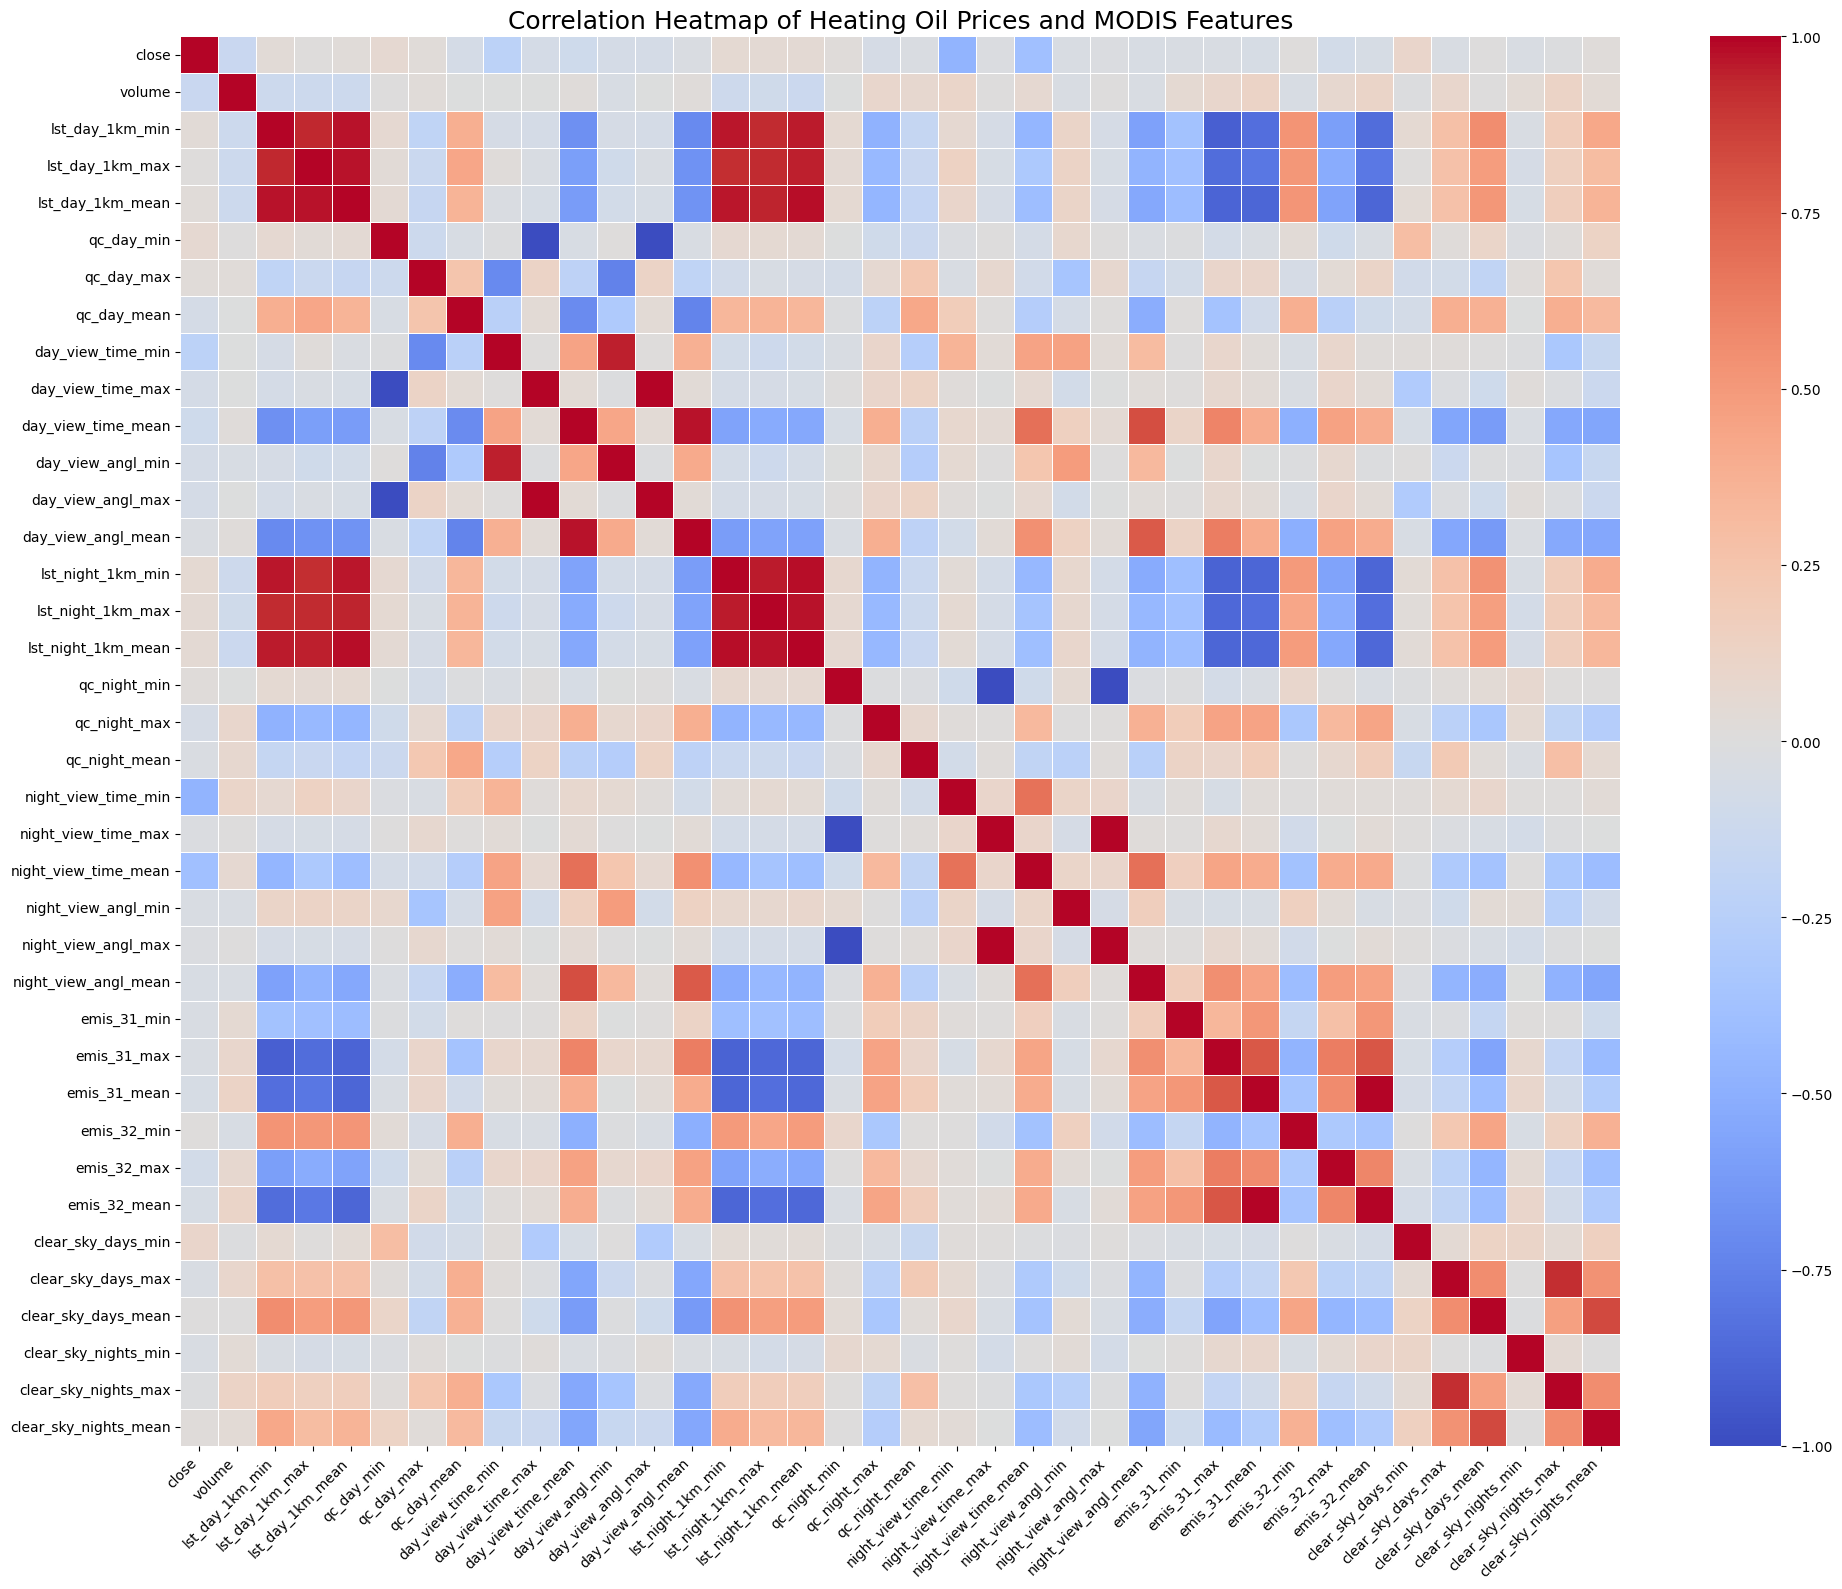

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Clean column names
merged_df.columns = merged_df.columns.str.strip().str.lower().str.replace('*', '', regex=False).str.replace(' ', '_')

# Convert 'volume' to numeric (handle non-numeric like '-') if needed
merged_df['volume'] = pd.to_numeric(merged_df['volume'].astype(str).str.replace(',', ''), errors='coerce')

# Drop rows with missing values in key numeric columns
merged_df = merged_df.dropna(subset=['close', 'volume'])

# Compute correlation matrix
corr_matrix = merged_df.corr(numeric_only=True)

# Plot correlation heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Heating Oil Prices and MODIS Features", fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [36]:
# List of MODIS features to lag
features_to_lag = [col for col in merged_df.columns if col.startswith('lst_') or col.startswith('emis_') or col.startswith('clear_sky_')]

# Number of lag days to include
lag_days = [1, 7, 14]

# Add lagged features
for col in features_to_lag:
    for lag in lag_days:
        merged_df[f'{col}_lag{lag}'] = merged_df[col].shift(lag)

# Drop rows with NaNs introduced by lags
merged_df = merged_df.dropna().reset_index(drop=True)

# Optional: Preview
merged_df[[col for col in merged_df.columns if 'lst_day_1km_mean' in col]].head()

,lst_day_1km_mean,lst_day_1km_mean_lag1,lst_day_1km_mean_lag7,lst_day_1km_mean_lag14
0,13478.423683,13478.423683,13264.638711,13233.65539
1,13355.700750,13478.423683,13264.638711,13233.65539
2,13355.700750,13355.700750,13264.638711,13233.65539
3,13355.700750,13355.700750,13264.638711,13233.65539
4,13355.700750,13355.700750,13478.423683,13233.65539


In [37]:
merged_df

,date,close,volume,lst_day_1km_min,lst_day_1km_max,lst_day_1km_mean,qc_day_min,qc_day_max,qc_day_mean,day_view_time_min,...,clear_sky_days_mean_lag14,clear_sky_nights_min_lag1,clear_sky_nights_min_lag7,clear_sky_nights_min_lag14,clear_sky_nights_max_lag1,clear_sky_nights_max_lag7,clear_sky_nights_max_lag14,clear_sky_nights_mean_lag1,clear_sky_nights_mean_lag7,clear_sky_nights_mean_lag14
0,2015-01-23,1.6467,29672.0,12452.0,14360.2,13478.423683,2.0,148.2,22.940498,101.2,...,66.504794,1.0,1.0,1.0,223.0,250.0,246.0,74.853699,100.281172,79.089341
1,2015-01-26,1.6398,37690.0,12342.6,14282.4,13355.700750,2.0,141.8,25.757469,100.4,...,66.504794,1.0,1.0,1.0,223.0,250.0,246.0,74.853699,100.281172,79.089341
2,2015-01-27,1.6628,23148.0,12342.6,14282.4,13355.700750,2.0,141.8,25.757469,100.4,...,66.504794,1.0,1.0,1.0,254.6,250.0,246.0,95.726609,100.281172,79.089341
3,2015-01-28,1.6318,29988.0,12342.6,14282.4,13355.700750,2.0,141.8,25.757469,100.4,...,66.504794,1.0,1.0,1.0,254.6,250.0,246.0,95.726609,100.281172,79.089341
4,2015-01-29,1.6184,28639.0,12342.6,14282.4,13355.700750,2.0,141.8,25.757469,100.4,...,66.504794,1.0,1.0,1.0,254.6,223.0,246.0,95.726609,74.853699,79.089341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2476,2024-12-24,2.2215,15731.0,12498.8,14378.4,13380.721097,2.0,151.4,22.024206,91.0,...,76.628872,1.0,1.0,1.0,253.0,234.0,252.2,82.092066,71.278346,99.097975
2477,2024-12-26,2.2053,17639.0,12553.2,14397.0,13695.490401,2.0,141.8,16.159336,91.6,...,76.628872,1.0,1.0,1.0,253.0,234.0,252.2,82.092066,71.278346,99.097975
2478,2024-12-27,2.2448,17139.0,12553.2,14397.0,13695.490401,2.0,141.8,16.159336,91.6,...,76.628872,1.2,1.0,1.0,58.0,234.0,252.2,26.159014,71.278346,99.097975
2479,2024-12-30,2.2995,19299.0,12553.2,14397.0,13695.490401,2.0,141.8,16.159336,91.6,...,76.628872,1.2,1.0,1.0,58.0,253.0,252.2,26.159014,82.092066,99.097975


In [38]:
merged_df['lst_day_1km_mean_roll7'] = merged_df['lst_day_1km_mean'].rolling(window=7).mean()
merged_df['lst_day_1km_mean_roll14'] = merged_df['lst_day_1km_mean'].rolling(window=14).mean()

In [39]:
merged_df

,date,close,volume,lst_day_1km_min,lst_day_1km_max,lst_day_1km_mean,qc_day_min,qc_day_max,qc_day_mean,day_view_time_min,...,clear_sky_nights_min_lag7,clear_sky_nights_min_lag14,clear_sky_nights_max_lag1,clear_sky_nights_max_lag7,clear_sky_nights_max_lag14,clear_sky_nights_mean_lag1,clear_sky_nights_mean_lag7,clear_sky_nights_mean_lag14,lst_day_1km_mean_roll7,lst_day_1km_mean_roll14
0,2015-01-23,1.6467,29672.0,12452.0,14360.2,13478.423683,2.0,148.2,22.940498,101.2,...,1.0,1.0,223.0,250.0,246.0,74.853699,100.281172,79.089341,NaN,NaN
1,2015-01-26,1.6398,37690.0,12342.6,14282.4,13355.700750,2.0,141.8,25.757469,100.4,...,1.0,1.0,223.0,250.0,246.0,74.853699,100.281172,79.089341,NaN,NaN
2,2015-01-27,1.6628,23148.0,12342.6,14282.4,13355.700750,2.0,141.8,25.757469,100.4,...,1.0,1.0,254.6,250.0,246.0,95.726609,100.281172,79.089341,NaN,NaN
3,2015-01-28,1.6318,29988.0,12342.6,14282.4,13355.700750,2.0,141.8,25.757469,100.4,...,1.0,1.0,254.6,250.0,246.0,95.726609,100.281172,79.089341,NaN,NaN
4,2015-01-29,1.6184,28639.0,12342.6,14282.4,13355.700750,2.0,141.8,25.757469,100.4,...,1.0,1.0,254.6,223.0,246.0,95.726609,74.853699,79.089341,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2476,2024-12-24,2.2215,15731.0,12498.8,14378.4,13380.721097,2.0,151.4,22.024206,91.0,...,1.0,1.0,253.0,234.0,252.2,82.092066,71.278346,99.097975,13416.000549,13466.010706
2477,2024-12-26,2.2053,17639.0,12553.2,14397.0,13695.490401,2.0,141.8,16.159336,91.6,...,1.0,1.0,253.0,234.0,252.2,82.092066,71.278346,99.097975,13443.327866,13477.704084
2478,2024-12-27,2.2448,17139.0,12553.2,14397.0,13695.490401,2.0,141.8,16.159336,91.6,...,1.0,1.0,58.0,234.0,252.2,26.159014,71.278346,99.097975,13470.655184,13489.397462
2479,2024-12-30,2.2995,19299.0,12553.2,14397.0,13695.490401,2.0,141.8,16.159336,91.6,...,1.0,1.0,58.0,253.0,252.2,26.159014,82.092066,99.097975,13515.622227,13501.090840


In [40]:
top_corrs = merged_df.corr(numeric_only=True)['close'].drop('close').sort_values(key=lambda x: abs(x), ascending=False)
top_corrs.head(20)

day_view_time_min           -0.496047
night_view_time_min         -0.466459
night_view_time_mean        -0.375500
volume                      -0.144891
clear_sky_days_min_lag1      0.095201
qc_day_mean                 -0.095105
clear_sky_days_min           0.095101
clear_sky_days_min_lag7      0.093103
clear_sky_days_min_lag14     0.083393
day_view_time_mean          -0.081044
emis_32_max_lag7            -0.075961
emis_32_max_lag1            -0.070037
emis_32_max                 -0.066964
qc_day_min                   0.066860
day_view_angl_max           -0.066860
day_view_time_max           -0.066860
emis_32_max_lag14           -0.064832
clear_sky_days_max          -0.061639
clear_sky_days_max_lag1     -0.059879
clear_sky_nights_max_lag7   -0.059071
Name: close, dtype: float64

## Evaluate Inference, Select Only Important Features

In [41]:
# Keep top correlated features manually (based on your list + expert pruning)
selected_features = [
    'date',
    'close',
    'volume',
    'day_view_time_min',            # Strongest signal
    'night_view_time_min',
    'clear_sky_days_min_lag7',      # Weather-related
    'emis_32_max_lag7',             # Surface signal
    'lst_day_1km_mean_lag7',        # Add back lagged temp (should help!)
    'lst_day_1km_mean_roll7',       # Smooth trend
]

# Drop all others
model_df = merged_df[selected_features].dropna()
model_df

,date,close,volume,day_view_time_min,night_view_time_min,clear_sky_days_min_lag7,emis_32_max_lag7,lst_day_1km_mean_lag7,lst_day_1km_mean_roll7
6,2015-02-02,1.7575,70834.0,100.4,208.6,1.0,250.0,13478.423683,13365.409782
7,2015-02-03,1.8465,69544.0,100.4,208.6,1.0,250.0,13478.423683,13340.055119
8,2015-02-04,1.7666,68864.0,100.4,208.6,1.0,250.0,13355.700750,13332.232304
9,2015-02-05,1.8059,64465.0,100.4,208.6,1.0,250.0,13355.700750,13324.409489
10,2015-02-06,1.8391,64500.0,100.4,208.6,1.0,250.0,13355.700750,13316.586673
...,...,...,...,...,...,...,...,...,...
2476,2024-12-24,2.2215,15731.0,91.0,200.0,1.0,250.0,13504.199180,13416.000549
2477,2024-12-26,2.2053,17639.0,91.6,200.6,1.0,250.0,13504.199180,13443.327866
2478,2024-12-27,2.2448,17139.0,91.6,200.6,1.0,250.0,13504.199180,13470.655184
2479,2024-12-30,2.2995,19299.0,91.6,200.6,1.0,250.0,13380.721097,13515.622227


In [42]:
model_df.to_csv("model_df.csv", index=False)